In [1]:
#libraries
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import soundfile as sf
import hashlib
from typing import List, Tuple
from scipy import signal
from scipy.io import wavfile
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import (binary_erosion,
                                      generate_binary_structure,
                                      iterate_structure)

C:\Users\juanj\AppData\Local\Temp\ipykernel_11672\1606119994.py:11: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import maximum_filter
C:\Users\juanj\AppData\Local\Temp\ipykernel_11672\1606119994.py:12: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import (binary_erosion,
C:\Users\juanj\AppData\Local\Temp\ipykernel_11672\1606119994.py:12: DeprecationWarning: Please use `generate_binary_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import (binary_erosion,
C:\Users\juanj\AppData\Local\Temp\ipykernel_11672\1606119994.py:12: DeprecationWarning: Please use `iterate_structure` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprec

In [2]:
#constants
wsize = 4096
wratio = 0.5
CONNECTIVITY_MASK = 8
DEFAULT_AMP_MIN = 10
DEFAULT_FAN_VALUE = 5  # 15 was the original value.

44100


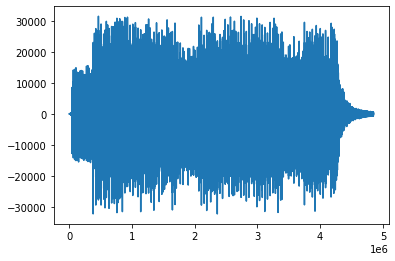

In [3]:

#read the audio file
#data, samplerate = sf.read('Lavender_Town_Japan.wav')
samplerate,data = wavfile.read('Lavender_Town_Japan.wav')
#convert to mono the signal
data = np.mean(data, axis=1)
print(samplerate)
#samplig input signal to 44100Hz
samplerate = 44100
#data= signal.resample(data, int(len(data)*samplerate/len(data)))
segmentSize=2
seconds = data.shape[0] / samplerate
segments = seconds / segmentSize
samplesPerSegment = int(data.shape[0] / segments)
#plot the audio file in time domain
plt.plot(data)
plt.show()

C:\Users\juanj\AppData\Local\Temp\ipykernel_11672\3648989442.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(212)
c:\Users\juanj\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_axes.py:7720: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


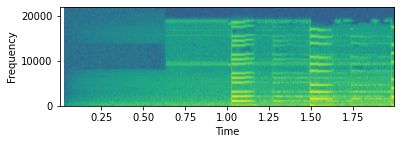

In [4]:
#continuos time processing
#using the fast fourier transform to convert the audio file to frequency domain
#fft = np.fft.fft(data)
#plot the audio file in frequency domain
#plt.plot(fft)
#plt.show()
plt.plot(data)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.subplot(212)
plt.specgram(data[0:samplesPerSegment],Fs=samplerate, mode='psd')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

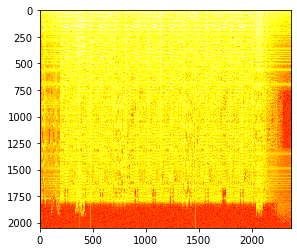

In [5]:
fft = np.fft.fft(data)
#peack finding from spectrogram
#peaks, _ = signal.find_peaks(fft, height=0)
#plt.plot(peaks, fft[peaks], "x")
#plt.plot(np.zeros_like(fft), "--", color="gray")
#plt.show()
#FFT the signal and extract frequency components
arr2D = mlab.specgram(data,NFFT=wsize,Fs=44100,window=mlab.window_hanning,noverlap=int(wsize * wratio))[0]

    # Apply log transform since specgram function returns linear array. 0s are excluded to avoid np warning.
arr2D = 10 * np.log10(arr2D, out=np.zeros_like(arr2D), where=(arr2D != 0))

#graphical representation of the spectrogram
plt.imshow(arr2D, cmap='hot', interpolation='nearest')
plt.show()

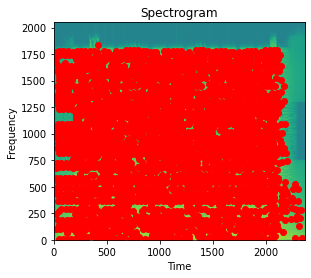

[(3, 52),
 (3, 93),
 (3, 124),
 (3, 165),
 (3, 206),
 (3, 227),
 (3, 268),
 (3, 309),
 (3, 453),
 (3, 494),
 (3, 535),
 (3, 597),
 (3, 638),
 (3, 720),
 (3, 761),
 (3, 864),
 (3, 905),
 (3, 946),
 (3, 967),
 (3, 1008),
 (3, 1049),
 (3, 1090),
 (3, 1131),
 (3, 1152),
 (3, 1193),
 (3, 1234),
 (3, 1275),
 (3, 1378),
 (3, 1419),
 (3, 1460),
 (3, 1501),
 (3, 1522),
 (3, 1563),
 (3, 1604),
 (3, 1686),
 (3, 1727),
 (3, 1748),
 (3, 1789),
 (3, 1830),
 (3, 1871),
 (3, 1912),
 (3, 1933),
 (3, 1974),
 (5, 576),
 (5, 2064),
 (6, 401),
 (9, 2033),
 (20, 2274),
 (20, 2345),
 (24, 809),
 (24, 948),
 (24, 985),
 (24, 1630),
 (24, 1651),
 (24, 1749),
 (24, 1809),
 (26, 310),
 (26, 639),
 (26, 660),
 (26, 1153),
 (26, 1461),
 (26, 1976),
 (27, 925),
 (30, 1073),
 (30, 1893),
 (31, 228),
 (31, 1050),
 (31, 1401),
 (31, 1938),
 (34, 743),
 (34, 1279),
 (35, 281),
 (35, 414),
 (35, 1102),
 (35, 1235),
 (36, 352),
 (36, 444),
 (36, 539),
 (36, 1359),
 (36, 1525),
 (36, 1854),
 (37, 375),
 (37, 1009),
 (37, 

In [6]:
#peack finding from spectrogram
def get_peaks(inputsignal,amp_min):
    struct = generate_binary_structure(2, CONNECTIVITY_MASK)
    neighborhood = iterate_structure(struct, 20)
    # Find local peaks using our fliter shape. Filtro pasa altos
    local_max = maximum_filter(inputsignal, footprint=neighborhood) == inputsignal
    background = (inputsignal == 0)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)
    # Boolean mask of arr2D with True at peaks.
    detected_peaks = local_max ^ eroded_background
    # Extract peaks
    amps = inputsignal[detected_peaks]
    freqs, times = np.where(detected_peaks)
    # Filter peaks
    amps = amps.flatten()
    #Get indices for frequency and time
    filteridx = np.where(amps > amp_min)
    freqs_filter = freqs[filteridx]
    times_filter = times[filteridx]

    #scatter plot of the peaks
    fig, ax = plt.subplots()
    ax.imshow(inputsignal)
    ax.scatter(times_filter, freqs_filter, c='r')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
    ax.set_title('Spectrogram')
    plt.gca().invert_yaxis()
    plt.show()

    return list(zip(freqs_filter, times_filter))


get_peaks(arr2D, DEFAULT_AMP_MIN)